# Generative Artificial Faces with CelebA Progressive GAN Models

## Setup

In [26]:
#Import the libraries:
from absl import logging
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.random.set_seed(0)
import tensorflow_hub as hub
import tensorflow_docs.vis as embed
import time
try:
  from google.colab import files
except ImportError:
  pass
from IPython import display
from skimage import transform

#Ignore the warnings:
import warnings
warnings.filterwarnings('ignore')


In [35]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

## Create the Random State

In [36]:
#Import Progressive GAN's :
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


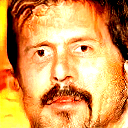

In [38]:
#Now apply the Interploated vectors:
def interpolate_between_vectors():
    # Define the vectors
    v1 = tf.random.normal([latent_dim])
    v2 = tf.random.normal([latent_dim])

#Create the vectors:
    vectors = interpolate_hypersphere(v1, v2, 50)

#Use the Model to generate the image from laten space:
    interpolated_images = progan(vectors)['default']
    return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)



# Choose the closest Image Vector from the dataset

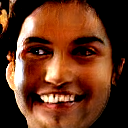

In [41]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

# Image generated based on the closeset dataset, so due to this reason shapes of images based on different vectors
# One image is latented based and second is closeset method based
# So this produced the loss function image due to difference between orginal and predicted image

In [42]:
# Produced the random state and seed to closed the images and reduce its differences.
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

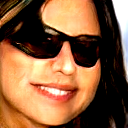

In [44]:
display_image(progan(initial_vector)['default'][0])

In [46]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
      
      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
    
  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 5250.214697265625)

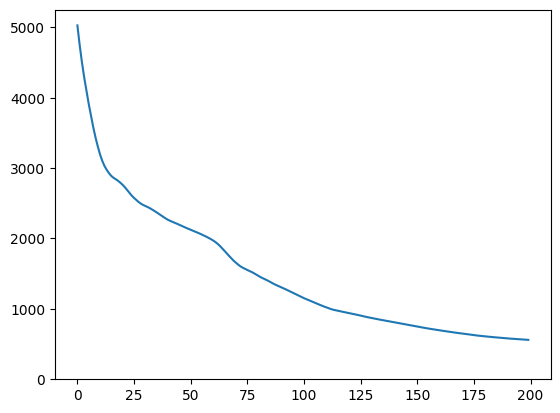

In [47]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


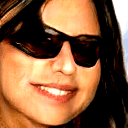

In [48]:
animate(np.stack(images))

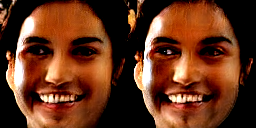

In [49]:
display_image(np.concatenate([images[-1], target_image], axis=1))